In [9]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import os
from tqdm import tqdm


In [2]:
train_mask=pd.read_csv('train_masks.csv')
metadata=pd.read_csv('metadata.csv')
submission=pd.read_csv('sample_submission.csv')

In [3]:
train_images= os.listdir('train')
test_images= os.listdir('test')
train_masks= os.listdir('train_masks')
train_path= [os.path.join('train',i) for i in os.listdir('train')]
test_path=[os.path.join('test',i) for i in os.listdir('test')]
mask_path=[os.path.join('train_masks',i) for i in os.listdir('train_masks')]

In [4]:
from PIL import Image
def plot_image_and_mask(train_images):
    #plot the train_images
    figure,axis=plt.subplots(len(train_images),2,figsize=(2*10,10*len(train_images)))
    for i in range(len(train_images)):
        id=train_images[i]
        image_path=os.path.join('train',id)
        mask_path=os.path.join('train_masks',id)[:-4]+'_mask.gif'
        print(np.array(Image.open(image_path)).shape)
        axis[i][0].imshow(Image.open(image_path))
        axis[i][1].imshow(Image.open(mask_path))

(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)
(1280, 1918, 3)


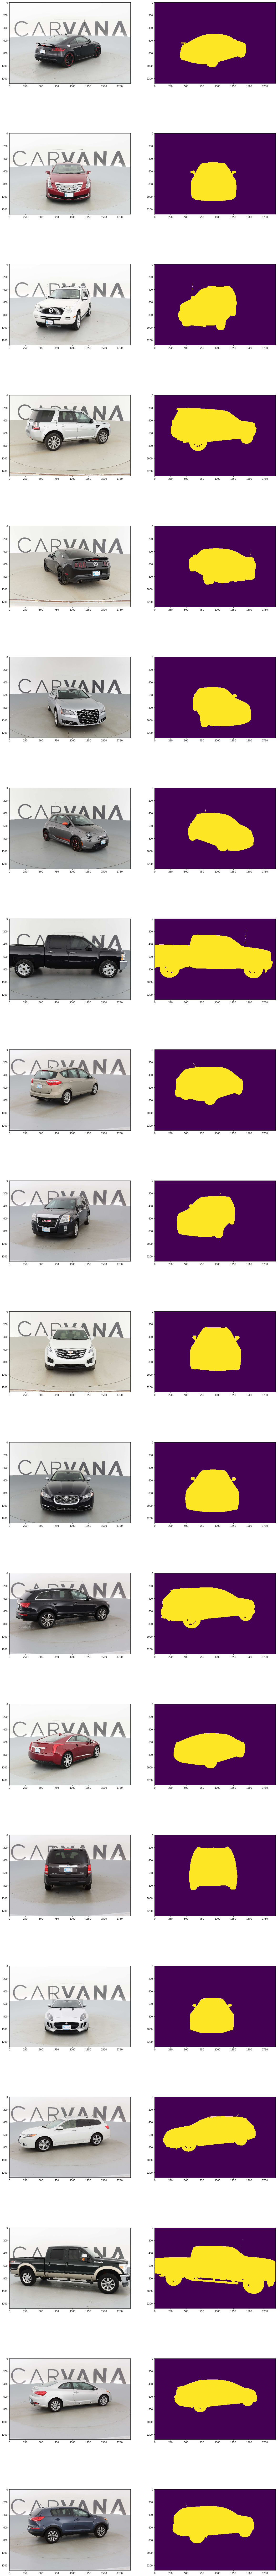

In [5]:
plot_image_and_mask(train_images[50:70])

shutil craetes symbolic link to the directories where the files are copied. When we create folds, the data does not disappear.

In [10]:
#test code to create the folds 
from pathlib import Path
import shutil
local_data_path=Path('.').absolute()/'folds'
local_data_path.mkdir(exist_ok=True)
train_path= Path('.').absolute()/'train_hq/'
mask_path=Path('.').absolute()/'train_masks'
train_file_list=train_images
folds=pd.read_csv('folds_csv.csv')
num_folds=folds.fold.nunique()
#the cars are at sixteen angles 
angles=['0'+ str(i) for i in range (1,10)]+ [str(i) for i in range(10,17)]
#now create the folder containing the folds 
for fold in range(num_folds):
    #create the folder correspoonding to number of folds
    (local_data_path / str(fold) / 'train' / 'images').mkdir(exist_ok=True, parents=True)
    (local_data_path / str(fold) / 'train' / 'masks').mkdir(exist_ok=True, parents=True)

    (local_data_path / str(fold) / 'val' / 'images').mkdir(exist_ok=True, parents=True)
    (local_data_path / str(fold) / 'val' / 'masks').mkdir(exist_ok=True, parents=True)

for i in tqdm(folds.index):
    car_id=folds.loc[i,'id']
    fold=folds.loc[i,'fold']
    #copy the 16 images to fold directory 
    #this is considered as a val this time 
    for angle in angles:
        old_image_path = train_path / (car_id + '_' + angle + '.jpg')

        new_image_path = local_data_path / str(fold) / 'val' / 'images' / (car_id + '_' + angle + '.jpg')
        shutil.copy(str(old_image_path), str(new_image_path))

        old_mask_path = mask_path / (car_id + '_' + angle + '_mask.gif')
        new_mask_path = local_data_path / str(fold) / 'val' / 'masks' / (car_id + '_' + angle + '_mask.gif')
        shutil.copy(str(old_mask_path), str(new_mask_path))
        
    #for all the other folds this will be considered as a  training image
    for t_fold in range(num_folds):
            if t_fold == fold:
                continue

            for angle in angles:
                old_image_path = train_path / (car_id + '_' + angle + '.jpg')

                new_image_path = local_data_path / str(t_fold) / 'train' / 'images' / (car_id + '_' + angle + '.jpg')
                shutil.copy(str(old_image_path), str(new_image_path))

                old_mask_path = mask_path / (car_id + '_' + angle + '_mask.gif')
                new_mask_path = local_data_path / str(t_fold) / 'train' / 'masks' / (car_id + '_' + angle + '_mask.gif')
                shutil.copy(str(old_mask_path), str(new_mask_path))


100%|██████████| 318/318 [03:57<00:00,  1.14it/s]


We take care of the modelling now. The original implementation used unet 11 with a pre-trained vgg-11 encoder, which is what we will use.

In [13]:
#modelling
from torch import nn 
from torch.nn import functional as F
import torch 
from torchvision import models

In [22]:
#a simple 3X3 convolution
def conv3X3(in_,out):
    return nn.Conv2d(in_,out,padding=1)

class Conv3BN(nn.Module):
    def __init__(self, in_: int, out: int, bn=False):
        super().__init__()
        self.conv = conv3x3(in_,out)
        self.bn= nn.BatchNorm2d(out) if bn else None
        self.activation =nn.SELU(inplace=True)
    
    def forward(self, x):
            x = self.conv(x)
            if self.bn is not None:
                x = self.bn(x)
            x = self.activation(x)
            return x